## Notebook example of ptychograpic reconstruction on simulated data

This is a basic example, showing how to:
* simulate data
* compute the object shape from the data
* use the Ptycho operators for reconstruction

In [1]:
# Optional: select language and/or GPU name or rank through environment variable
#import os
#os.environ['PYNX_PU'] = 'cuda'

%matplotlib notebook
import matplotlib.pyplot as plt
from pynx.ptycho import simulation, shape

# Import Ptycho, PtychoData and operators (automatically selecting OpenCL or CUDA)
from pynx.ptycho import *

## Simulate the Ptychography dataset

In [2]:
# 2D detector size (square)
nxy = 256
# Pixel size in meters
pixel_size_detector = 55e-6
# Wavelength in meters
wavelength = 1.5e-10
# Detector distance in meters
detector_distance = 1

# Object options 'siemens' simulates Siemens star (with a few holes)
# 'logo' simulates PyNX logo
# obj_info = {'type': 'logo', 'phase_stretch': 1.57, 'alpha_win': .2}
obj_info = {'type': 'siemens', 'phase_stretch': 1.57, 'alpha_win': .2}

# Probe description, either as a Gaussian, or as a focused aperture
probe_info = {'type': 'focus', 'aperture': (150e-6, 150e-6), 'focal_length': .08,
              'defocus': 350e-6, 'shape': (nxy, nxy)}
# probe_info = {'type': 'gauss', 'sigma_pix': (20, 20), 'shape': (nxy, nxy)}

# Spiral scan: 50 positions = 4 turns, 78 = 5 turns, 113 = 6 turns
scan_info = {'type': 'spiral', 'scan_step_pix': 20, 'n_scans': 200}

# Data info, with the different parameters and using Poisson noise
# nb_photons_per_frame is the average number of photons per frame
data_info = {'nb_photons_per_frame': 1e9, 'bg': 0, 'wavelength': wavelength,
             'detector_distance': detector_distance,
             'detector_pixel_size': pixel_size_detector,
             'noise': 'poisson'}

# Initialisation of the simulation
s = simulation.Simulation(obj_info=obj_info, probe_info=probe_info, scan_info=scan_info, data_info=data_info)
s.make_data()
posx, posy = s.scan.values
pixel_size_object = wavelength * detector_distance / pixel_size_detector / nxy
ampl = s.amplitude.values  # square root of the measured diffraction pattern intensity


Simulating object: siemens
Simulating probe: focus
Simulating scan: spiral
Simulating ptychographic data [200 frames].


Parameters of the simulation:
Data info: {'pix_size_direct_nm': 10, 'num_phot_max': None, 'nb_photons_per_frame': 1000000000.0, 'bg': 0, 'beam_stop_transparency': 0, 'noise': 'poisson', 'wavelength': 1.5e-10, 'detector_distance': 1, 'detector_pixel_size': 5.5e-05}
Scan info: {'type': 'spiral', 'scan_step_pix': 20, 'n_scans': 200, 'integer_values': True}
Object info: {'type': 'Custom', 'phase_stretch': 1.57, 'alpha_win': 0.2}
Probe info: {'type': 'focus', 'shape': (256, 256), 'sigma_pix': (50, 50), 'rotation': 0, 'aperture': (0.00015, 0.00015), 'focal_length': 0.08, 'defocus': 0.00035}


## Prepare the initial object and probe
This uses the `pynx.ptycho.simulation` module for an explicit simulation of object and probe.

Note that if the initial object array is not supplied to the `Ptycho`object (`obj=None`), its size will be automatically calculated, and the object initialised to an homogeneous object (array of 1)

In [3]:
# Size of the reconstructed object
nyo, nxo = shape.calc_obj_shape(posx, posy, ampl.shape[1:])

# Initial object
obj_init_info = {'type': 'random', 'range': (0.9, 1, 0, 0.5), 'shape': (nyo, nxo)}

# Initial probe
probe_init_info = {'type': 'focus', 'aperture': (150e-6, 150e-6), 'focal_length': .08,
              'defocus': 250e-6, 'shape': (nxy, nxy)}

# Basic data info, used to compute the object pixel size
data_info = {'wavelength': wavelength, 'detector_distance': detector_distance,
             'detector_pixel_size': pixel_size_detector}
# Perform the actual simulation
init = simulation.Simulation(obj_info=obj_init_info, probe_info=probe_init_info, data_info=data_info)
init.make_obj()
init.make_probe()

Simulating object: random
Simulating probe: focus


## Create the `PtychoData` and `Ptycho` objects

In [4]:
data = PtychoData(iobs=ampl ** 2, positions=(posx * pixel_size_object, posy * pixel_size_object), 
                  detector_distance=1, mask=None, pixel_size_detector=55e-6, wavelength=1.5e-10)

# Random object start
p = Ptycho(probe=init.probe.values, obj=init.obj.values, data=data, background=None) 

# Initial scaling of object and probe
p = ScaleObjProbe(verbose=True) * p

ScaleObjProbe: 3191.7007 328418.25 950.6346361420109 312.7586915335168 3.0395147349118945


## Optimise the Ptycho object 
This can use different algorithms:
* Difference Map
* Alternating Projections
* Maximum Likelihood conjugate gradient

For each algorithm it is possible to update object, probe, positions, and to display the result.

Each algorithm operator is elevated to the the number of cycles, e.g. `DM()**40` will perform 40 cycles

<IPython.core.display.Javascript object>


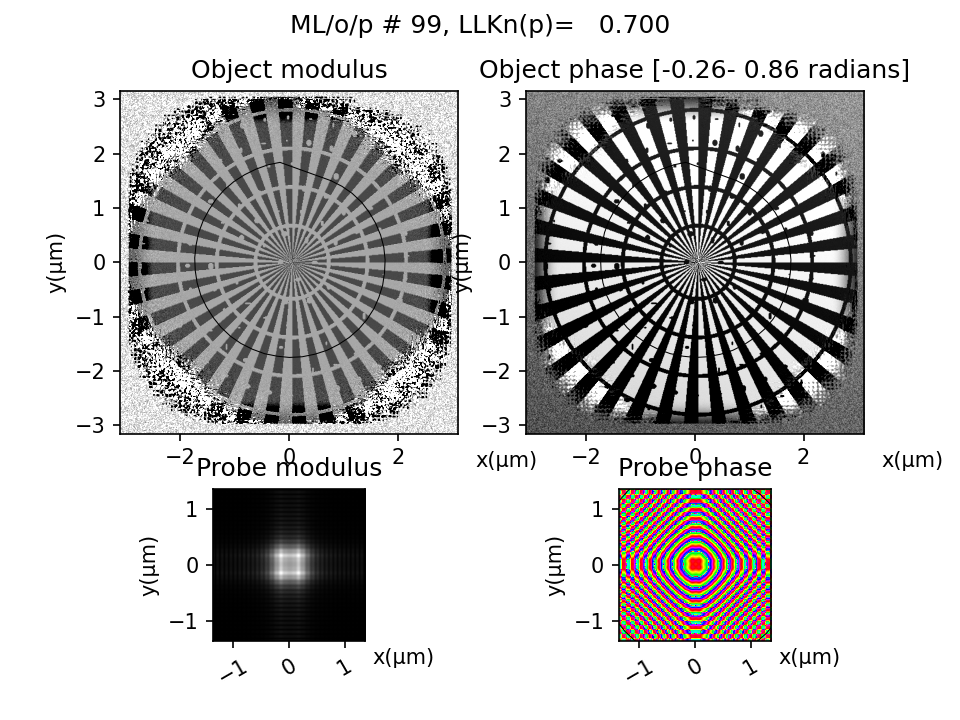

DM/o/p     #  0 LLK=  3389.05(p) 11305.04(g)  5282.56(e), nb photons=1.795044e+11, dt/cycle=0.668s
DM/o/p     # 20 LLK=    47.66(p)    58.07(g)    75.14(e), nb photons=1.989901e+11, dt/cycle=0.053s
DM/o/p     # 40 LLK=     1.76(p)     3.41(g)     3.49(e), nb photons=1.999057e+11, dt/cycle=0.030s
DM/o/p     # 60 LLK=     0.97(p)     1.83(g)     1.92(e), nb photons=1.998767e+11, dt/cycle=0.028s
DM/o/p     # 80 LLK=     1.11(p)     2.04(g)     2.18(e), nb photons=1.998223e+11, dt/cycle=0.028s
DM/o/p     # 99 LLK=     1.28(p)     2.33(g)     2.50(e), nb photons=1.997815e+11, dt/cycle=0.028s
ML/o/p     #101 LLK=     0.80(p)     1.58(g)     1.60(e), nb photons=2.001994e+11, dt/cycle=0.350s
ML/o/p     #121 LLK=     0.74(p)     1.48(g)     1.49(e), nb photons=1.999968e+11, dt/cycle=0.038s
ML/o/p     #141 LLK=     0.73(p)     1.46(g)     1.47(e), nb photons=2.000031e+11, dt/cycle=0.034s
ML/o/p     #161 LLK=     0.72(p)     1.44(g)     1.44(e), nb photons=2.000009e+11, dt/cycle=0.033s
ML/o/p    

In [5]:
plt.figure()
p = DM(update_object=True, update_probe=True, calc_llk=20, show_obj_probe=20)**100 * p
#p = ShowObjProbe() * AP(update_object=True, update_probe=False, calc_llk=10)**40 * p
p = ML(update_object=True, update_probe=True, calc_llk=20, show_obj_probe=20)**100 * p

## Use DM and ML options to smooth the object and/or probe
For DM or AP, use the `*_smooth_sigma` and `*_inertia` parameters
For ML, use the `reg_fac_*` parameters to 

<IPython.core.display.Javascript object>


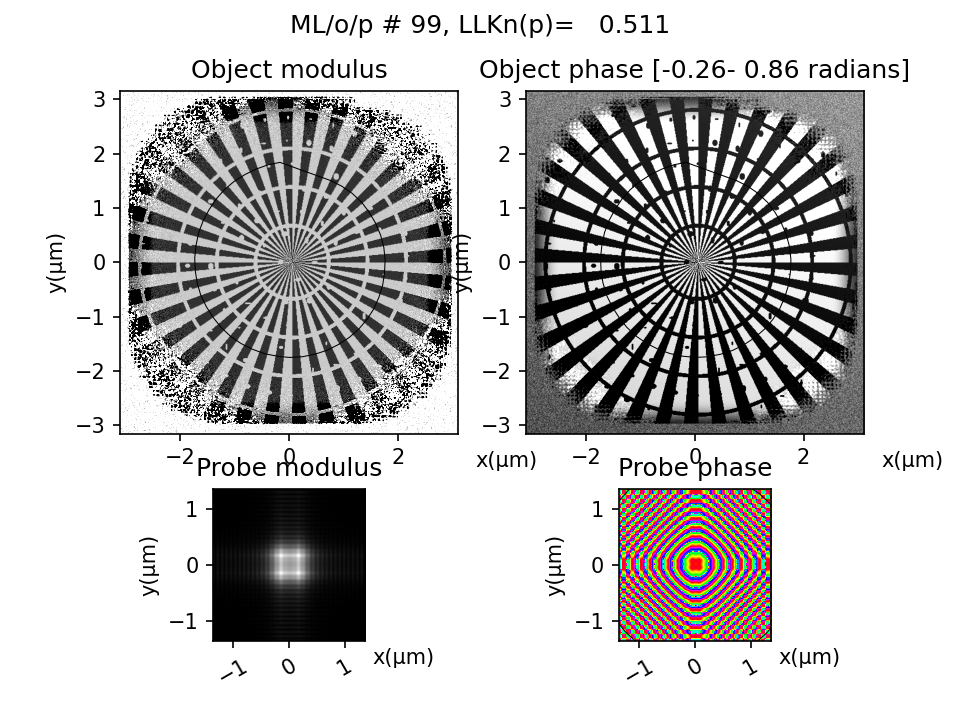

DM/o/p     #201 LLK=     0.62(p)     1.25(g)     1.25(e), nb photons=1.999947e+11, dt/cycle=0.279s
DM/o/p     #221 LLK=     0.61(p)     1.17(g)     1.22(e), nb photons=1.999401e+11, dt/cycle=0.028s
DM/o/p     #240 LLK=     0.73(p)     1.36(g)     1.44(e), nb photons=1.998794e+11, dt/cycle=0.028s
ML/o/p     #242 LLK=     0.53(p)     1.04(g)     1.06(e), nb photons=2.001080e+11, dt/cycle=0.183s
ML/o/p     #262 LLK=     0.51(p)     1.02(g)     1.03(e), nb photons=1.999972e+11, dt/cycle=0.034s
ML/o/p     #282 LLK=     0.51(p)     1.02(g)     1.03(e), nb photons=2.000003e+11, dt/cycle=0.034s
ML/o/p     #302 LLK=     0.51(p)     1.02(g)     1.03(e), nb photons=1.999996e+11, dt/cycle=0.033s
ML/o/p     #322 LLK=     0.51(p)     1.02(g)     1.03(e), nb photons=1.999993e+11, dt/cycle=0.033s
ML/o/p     #341 LLK=     0.51(p)     1.02(g)     1.03(e), nb photons=1.999993e+11, dt/cycle=0.036s


In [6]:
plt.figure()  # Create a new figure instead of using the one in the previous cell
p = DM(update_object=True, update_probe=True, calc_llk=20, show_obj_probe=20,
       obj_smooth_sigma=0.1, obj_inertia=0.01, probe_smooth_sigma=0.05, probe_inertia=0.001)**40 * p

p = ML(update_object=True, update_probe=True, show_obj_probe=20,
       calc_llk=20, reg_fac_obj=0.01, reg_fac_probe=0)**100 * p


## Add probe modes and continue optimising
The `DM/o/3p` indicates:
* the algorithm (DM or AP or ML)
* the parts which are optimised (o for object, p for probe, t for translations)
* the number of modes (when >1)

(in this case with simulated data, the additional probe modes are not useful)

<IPython.core.display.Javascript object>


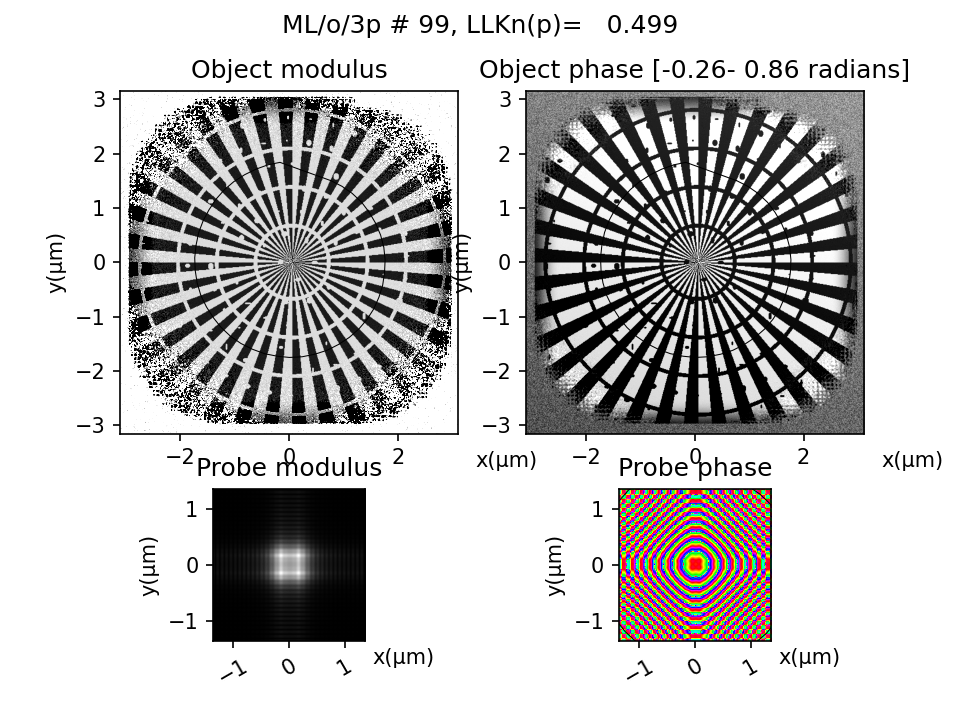

DM/o/3p    #342 LLK=     1.53(p)     6.54(g)     3.50(e), nb photons=1.999859e+11, dt/cycle=0.687s
DM/o/3p    #362 LLK=     0.58(p)     1.11(g)     1.16(e), nb photons=1.999418e+11, dt/cycle=0.056s
DM/o/3p    #381 LLK=     0.72(p)     1.34(g)     1.41(e), nb photons=1.998777e+11, dt/cycle=0.034s
ML/o/3p    #383 LLK=     0.52(p)     1.02(g)     1.03(e), nb photons=2.001098e+11, dt/cycle=0.153s
ML/o/3p    #403 LLK=     0.50(p)     1.00(g)     1.01(e), nb photons=1.999962e+11, dt/cycle=0.052s
ML/o/3p    #423 LLK=     0.50(p)     1.00(g)     1.01(e), nb photons=1.999989e+11, dt/cycle=0.051s
ML/o/3p    #443 LLK=     0.50(p)     1.00(g)     1.01(e), nb photons=1.999988e+11, dt/cycle=0.051s
ML/o/3p    #463 LLK=     0.50(p)     1.00(g)     1.01(e), nb photons=1.999994e+11, dt/cycle=0.051s
ML/o/3p    #482 LLK=     0.50(p)     1.00(g)     1.01(e), nb photons=1.999992e+11, dt/cycle=0.051s


In [7]:
pr = p.get_probe()
nb_probe, ny, nx = pr.shape
# New number of probe modes
nb_probe = 3 
pr1 = np.empty((nb_probe, ny, nx), dtype=np.complex64)
pr1[0] = pr[0]
for i in range(1, nb_probe):
    n = abs(pr).mean() / 10
    pr1[i] = np.random.uniform(0, n, (ny, nx)) * np.exp(1j * np.random.uniform(0,2*np.pi, (ny,nx)))

p.set_probe(pr1)

plt.figure()
p = DM(update_object=True, update_probe=True, calc_llk=20, show_obj_probe=20)**40 * p
p = ML(update_object=True, update_probe=True, calc_llk=20, show_obj_probe=20)**100 * p


In [8]:
# Manual decompositon of algorithms
#p = Psi2Obj() * PropagateApplyAmplitude()* ObjProbe2Psi() * SelectStack(0) * p
#p = Psi2ObjMerge() * LoopStack(Psi2Obj() * PropagateApplyAmplitude() * ObjProbe2Psi()) * p

## Export data and/or result object & probe to CXI (hdf5) files

In [9]:
if False:
    # 
    p.save_obj_probe_cxi('obj_probe.cxi')
    save_ptycho_data_cxi('data.cxi', ampl ** 2, pixel_size_detector, wavelength, detector_distance,
                         posx * pixel_size_object, posy * pixel_size_object, z=None, monitor=None,
                         mask=None, instrument='simulation', overwrite=True)
